In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [24]:
#read in data set
df = pd.read_csv('data.csv')
df = df.drop([441, 440, 439], axis = 0)
df['dietaryWater'] = df['dietaryWater'].replace(0, np.nan)

,time,heartRateVariabilitySDNN,dietarySugar,restingHeartRate,timeNightDeep,bodyMass,sleepEfficiency,dietaryWater,stepCount,dietaryPotassium,...,percentageSleepRem,distanceWalkingRunning,dietarySodium,dietaryIron,timeNightLight,sleepWakeups,walkingHeartRateAverage,heartRateVariabilitySDNN_tomorrow,heartRateVariabilitySDNN_mean,heartRateVariabilitySDNN_target
0,2022-01-23,41.249082,0.000000,66.000000,97.419998,183.399994,90.529976,NaN,11060.0,NaN,...,25.940001,6.076940,0.000000,NaN,282.230011,6.0,99.000000,39.531655,41.249082,0
1,2022-01-24,39.531655,0.000000,65.000000,63.430000,183.399994,86.735321,NaN,12048.0,NaN,...,23.660000,5.515179,0.000000,NaN,243.770004,8.0,99.000000,43.976979,40.390368,1
2,2022-01-25,43.976979,0.000000,65.000000,83.919998,183.399994,93.005234,NaN,10441.0,NaN,...,22.740000,4.613196,0.000000,NaN,252.270004,6.0,99.000000,43.976979,41.585905,1
3,2022-01-26,43.976979,0.000000,65.000000,0.000000,183.399994,90.529976,NaN,11290.0,NaN,...,25.940001,5.402965,0.000000,NaN,0.000000,0.0,99.000000,40.793000,42.183674,0
4,2022-01-27,40.793000,0.000000,64.000000,55.919998,183.399994,96.220390,NaN,14708.0,NaN,...,20.129999,8.285789,0.000000,NaN,314.820007,4.0,99.000000,40.793000,41.905539,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,2024-03-22,54.135118,0.000000,59.333333,65.470001,179.610611,94.406105,8.000000,14708.0,0.00000,...,17.090000,8.597617,0.000000,0.000000,287.750000,8.0,89.200000,66.755051,46.289210,1
435,2024-03-23,66.755051,18.045298,58.000000,75.959999,180.139709,95.282471,14.022582,8301.0,1184.20250,...,21.690001,4.628564,1318.338350,7.038947,708.440002,22.0,87.000000,34.935975,49.500277,0
436,2024-03-24,34.935975,38.926520,63.666667,113.959999,180.139709,92.642429,18.155679,1368.0,2155.65036,...,18.809999,0.656331,1328.244621,4.659715,763.299988,36.0,66.666667,38.499280,47.807616,0
437,2024-03-25,38.499280,0.000000,59.400000,42.000000,180.139709,94.387146,8.000000,6117.0,0.00000,...,16.940001,3.097591,0.000000,0.000000,272.279999,9.0,91.500000,45.216258,46.239116,0


In [25]:
#drop columns with over 10% NaN values
largeNa = []
for col in df:
    if df[col].isna().sum() >= (df.shape[0] / 10):
        largeNa.append(col)
df = df.drop(largeNa, axis = 1)

In [26]:
df['heartRateVariabilitySDNN_target'] = df['heartRateVariabilitySDNN_target'].astype(float)
times = df['time']
df = df.drop(['time'], axis = 1)

In [27]:
#use SVD to fill in remaining NaN
from numpy.linalg import svd
cols = df.columns
dfMatrix = df.to_numpy()

mean_imputed_matrix = np.nanmean(dfMatrix, axis = 0)
dfMatrix_copy = dfMatrix.copy()
dfMatrix_copy[np.isnan(dfMatrix_copy)] = np.take(mean_imputed_matrix, np.where(np.isnan(dfMatrix_copy))[1])

normalized_dfMatrix = (dfMatrix_copy - np.mean(dfMatrix_copy, axis = 0) / np.std(dfMatrix_copy, axis = 0))

U, S, VT = svd(normalized_dfMatrix)

rank = 20
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
VT_ranked = VT[:rank, :]
reconstructed_dfMatrix = U_ranked.dot(S_ranked).dot(VT_ranked)

denormalized_dfMatrix = (reconstructed_dfMatrix * np.std(dfMatrix_copy, axis = 0)) + np.mean(dfMatrix_copy, axis = 0)

complete_dfMatrix = dfMatrix.copy()
missing_indices = np.isnan(dfMatrix)
complete_dfMatrix[missing_indices] = denormalized_dfMatrix[missing_indices]

dfFull = pd.DataFrame(complete_dfMatrix, columns = cols)

#normalize data
dfNormal = (dfFull - dfFull.mean()) / dfFull.std()

In [30]:
#build model without HRV data
X1 = dfNormal.drop(['heartRateVariabilitySDNN', 'heartRateVariabilitySDNN_tomorrow', 'heartRateVariabilitySDNN_mean', 
                 'heartRateVariabilitySDNN_target'], axis =1)
X1 = sm.add_constant(X1)
y1 = dfNormal['heartRateVariabilitySDNN']

In [31]:
#split into train and test set
train_prop = 0.8
n = len(X1)
t = int(train_prop*n)
X1_train = X1.iloc[:t]
X1_test = X1.iloc[t:]
y1_train = y1.iloc[:t]
y1_test = y1.iloc[t:]

In [32]:
#build and fit OLS model
model1 = sm.OLS(y1_train, X1_train)
result1 = model1.fit()

In [33]:
#compute train and test mean square error
w1 = np.array(result1.params).reshape([len(result1.params),1])

train_pred1 = np.matmul(X1_train,w1)
test_pred1 = np.matmul(X1_test,w1)

y1_trainList = y1_train.tolist()
train_pred1List = train_pred1[0].tolist()
n = len(y1_trainList)
diffTrain = []
total = 0
for i in range(n):
    diffS = (y1_trainList[i] - train_pred1List[i]) **2
    diffTrain.append(diffS)
    total += diffS

train_MSE1 = total / n

y1_testList = y1_test.tolist()
test_pred1List = test_pred1[0].tolist()
n = len(y1_testList)
diffTest = []
total = 0
for i in range(n):
    diffS = (y1_testList[i] - test_pred1List[i]) **2
    diffTest.append(diffS)
    total += diffS

test_MSE1 = total / n

print('Train MSE = ' + str(train_MSE1))
print('Test MSE = ' + str(test_MSE1))
print('R Squared = ' + str(result1.rsquared))

Train MSE = 0.9418809522065102
Test MSE = 0.2707809907238298
R Squared = 0.23439653444201014


(array([341.,   3.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   3.]),
 array([1.19769026e-06, 4.75938849e+00, 9.51877578e+00, 1.42781631e+01,
        1.90375504e+01, 2.37969376e+01, 2.85563249e+01, 3.33157122e+01,
        3.80750995e+01, 4.28344868e+01, 4.75938741e+01]),
 <BarContainer object of 10 artists>)

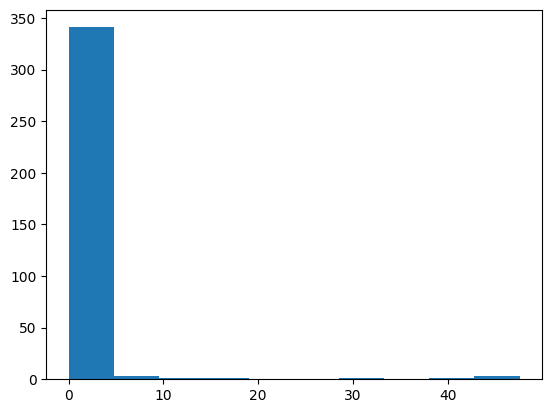

In [34]:
plt.hist(diffTrain)

(array([54., 16.,  5.,  3.,  2.,  3.,  2.,  2.,  0.,  1.]),
 array([1.06560598e-06, 1.91232854e-01, 3.82464643e-01, 5.73696431e-01,
        7.64928220e-01, 9.56160009e-01, 1.14739180e+00, 1.33862359e+00,
        1.52985537e+00, 1.72108716e+00, 1.91231895e+00]),
 <BarContainer object of 10 artists>)

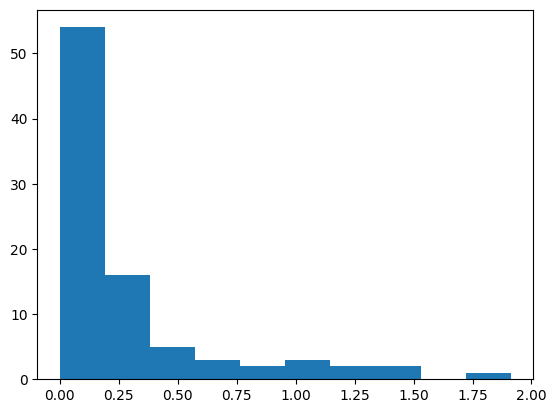

In [35]:
plt.hist(diffTest)

In [36]:
#train error is significantly larger than test error. Abnormal case, plotting shows this is caused by outliers in train set.
#Switch to using Huber loss function instead of least squares since it is more robust to outliers.
from sklearn.linear_model import HuberRegressor


huber = HuberRegressor(epsilon=1, max_iter= 100000, fit_intercept=True, alpha=0).fit(X1_train,y1_train)
w_huber = huber.coef_
huber_train_pred1 = np.matmul(X1_train,np.array(w_huber))
huber_test_pred1 = np.matmul(X1_test,np.array(w_huber))

y1_trainList = y1_train.tolist()
train_pred1List = huber_train_pred1.tolist()
n = len(y1_trainList)
diffTrain = []
total = 0
for i in range(n):
    diffS = (y1_trainList[i] - train_pred1List[i]) **2
    diffTrain.append(diffS)
    total += diffS

train_MSE1 = total / n

y1_testList = y1_test.tolist()
test_pred1List = huber_test_pred1.tolist()
n = len(y1_testList)
diffTest = []
total = 0
for i in range(n):
    diffS = (y1_testList[i] - test_pred1List[i]) **2
    diffTest.append(diffS)
    total += diffS

test_MSE1 = total / n

print('Train MSE = ' + str(train_MSE1))
print('Test MSE = ' + str(test_MSE1))
print('R Squared = ' + str(huber.score(X1_train, y1_train)))

Train MSE = 1.2451606223243659
Test MSE = 0.05171217452305938
R Squared = -0.02689714161011847


Text(0, 0.5, 'Frequency')

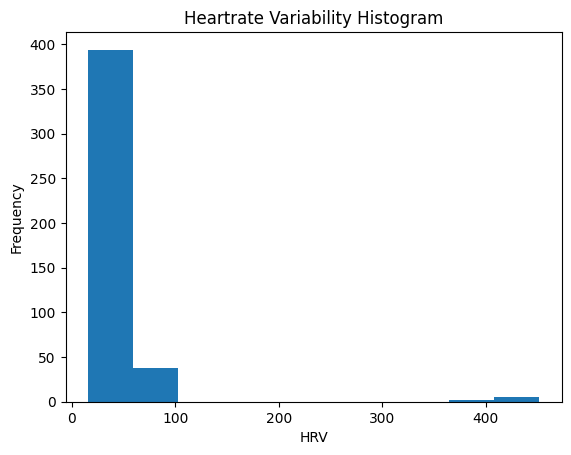

In [37]:
#still higher train error, check data to find outliers
plt.hist(dfFull['heartRateVariabilitySDNN'])
plt.title('Heartrate Variability Histogram')
plt.xlabel('HRV')
plt.ylabel('Frequency')

In [38]:
#plot shows a few larger outliers, probabily incorrect data, so remove them.
dfInliers = dfFull[dfFull['heartRateVariabilitySDNN'] < 200]
dfInliersNormal = (dfInliers - dfInliers.mean()) / dfInliers.std()

In [39]:
#build model without HRV data using normalized data without outliers in HRV
X2 = dfInliersNormal.drop(['heartRateVariabilitySDNN', 'heartRateVariabilitySDNN_tomorrow', 'heartRateVariabilitySDNN_mean', 
                 'heartRateVariabilitySDNN_target'], axis =1)
X2 = sm.add_constant(X2)
y2 = dfInliersNormal['heartRateVariabilitySDNN']

#split into train and test set
train_prop = 0.8
n = len(X2)
t = int(train_prop*n)
X2_train = X2.iloc[:t]
X2_test = X2.iloc[t:]
y2_train = y2.iloc[:t]
y2_test = y2.iloc[t:]

#build and fit OLS model
model2 = sm.OLS(y2_train, X2_train)
result2 = model2.fit()

#compute train and test mean square error
w2 = np.array(result2.params).reshape([len(result2.params),1])

train_pred2 = np.matmul(X2_train,w2)
test_pred2 = np.matmul(X2_test,w2)

y2_trainList = y2_train.tolist()
train_pred2List = train_pred2[0].tolist()
n = len(y2_trainList)
diffTrain = []
total = 0
for i in range(n):
    diffS = (y2_trainList[i] - train_pred2List[i]) **2
    diffTrain.append(diffS)
    total += diffS

train_MSE2 = total / n

y2_testList = y2_test.tolist()
test_pred2List = test_pred2[0].tolist()
n = len(y2_testList)
diffTest = []
total = 0
for i in range(n):
    diffS = (y2_testList[i] - test_pred2List[i]) **2
    diffTest.append(diffS)
    total += diffS

test_MSE2 = total / n

print('Train MSE = ' + str(train_MSE2))
print('Test MSE = ' + str(test_MSE2))
print('R Squared = ' + str(result2.rsquared))

Train MSE = 0.756202664411714
Test MSE = 1.3902604718100489
R Squared = 0.17877979562693436


In [40]:
#Train error no longer larger than test error, so removing outliers works.
#removing features in order to have model generalize better
print(result2.summary())

                               OLS Regression Results                               
Dep. Variable:     heartRateVariabilitySDNN   R-squared:                       0.179
Model:                                  OLS   Adj. R-squared:                  0.103
Method:                       Least Squares   F-statistic:                     2.365
Date:                      Fri, 10 May 2024   Prob (F-statistic):           0.000158
Time:                              18:35:06   Log-Likelihood:                -441.33
No. Observations:                       345   AIC:                             942.7
Df Residuals:                           315   BIC:                             1058.
Df Model:                                29                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [41]:
dfSlimNormal = dfInliersNormal.drop(['dietarySugar', 'restingHeartRate', 'timeNightDeep', 'sleepEfficiency', 'stepCount', 'dietaryFatSaturated',
                              'appleExerciseTime', 'vO2Max', 'timeSleepAwake', 'dietaryProtein', 'timeNightAwake', 'sleepLatency', 
                              'activeEnergyBurned', 'timeNightRem', 'heartRate', 'distanceWalkingRunning', 'dietarySodium', 'timeNightLight',
                              'sleepWakeups', 'heartRateVariabilitySDNN', 'heartRateVariabilitySDNN_tomorrow', 'heartRateVariabilitySDNN_mean', 
                              'heartRateVariabilitySDNN_target'], axis = 1)

In [42]:
#build model using select columns of normalized data without outliers in HRV
X3 = dfSlimNormal
X3 = sm.add_constant(X3)
y3 = dfInliersNormal['heartRateVariabilitySDNN']

#split into train and test set
train_prop = 0.8
n = len(X3)
t = int(train_prop*n)
X3_train = X3.iloc[:t]
X3_test = X3.iloc[t:]
y3_train = y3.iloc[:t]
y3_test = y3.iloc[t:]

#build and fit OLS model
model3 = sm.OLS(y3_train, X3_train)
result3 = model3.fit()

#compute train and test mean square error
w3 = np.array(result3.params).reshape([len(result3.params),1])

train_pred3 = np.matmul(X3_train,w3)
test_pred3 = np.matmul(X3_test,w3)

y3_trainList = y3_train.tolist()
train_pred3List = train_pred3[0].tolist()
n = len(y3_trainList)
diffTrain = []
total = 0
for i in range(n):
    diffS = (y3_trainList[i] - train_pred3List[i]) **2
    diffTrain.append(diffS)
    total += diffS

train_MSE3 = total / n

y3_testList = y3_test.tolist()
test_pred3List = test_pred3[0].tolist()
n = len(y3_testList)
diffTest = []
total = 0
for i in range(n):
    diffS = (y3_testList[i] - test_pred3List[i]) **2
    diffTest.append(diffS)
    total += diffS

test_MSE3 = total / n

print('Train MSE = ' + str(train_MSE3))
print('Test MSE = ' + str(test_MSE3))
print('R Squared = ' + str(result3.rsquared))

Train MSE = 0.7759332224663398
Test MSE = 1.2143153784974319
R Squared = 0.15735282415412188


In [43]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     heartRateVariabilitySDNN   R-squared:                       0.157
Model:                                  OLS   Adj. R-squared:                  0.132
Method:                       Least Squares   F-statistic:                     6.237
Date:                      Fri, 10 May 2024   Prob (F-statistic):           9.20e-09
Time:                              18:35:06   Log-Likelihood:                -445.77
No. Observations:                       345   AIC:                             913.5
Df Residuals:                           334   BIC:                             955.8
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0101      0.052     -0.195      0.845      -0.112       0.092
bodyMass                 -0.2286      0.157     -1.453      0.147      -0.538       0.081
dietaryCarbohydrates     -0.2058      0.116     -1.772      0.077      -0.434       0.023
dietaryCholesterol        0.1100      0.071      1.552      0.122      -0.029       0.249
bodyMassIndex             0.3425      0.160      2.143      0.033       0.028       0.657
dietaryEnergyConsumed     0.0636      0.065      0.978      0.329      -0.064       0.191
dietaryFatTotal          -0.2458      0.126     -1.946      0.053      -0.494       0.003
dietaryFiber              0.4429      0.106      4.159      0.000       0.233       0.652
respiratoryRate          -0.1307      0.067     -1.941      0.053      -0.263       0.002
timeNightAsleep           0.2594      0.073      3.538      0.000       0.115       0.404
timeNightInBed           -0.2886      0.068     -4.214      0.000      -0.423      -0.154
==============================================================================
Omnibus:                       31.314   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.204
Skew:                           0.531   Prob(JB):                     2.30e-13
Kurtosis:                       4.710   Cond. No.                         8.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
#build huber model with select columns of normalized without outliers in HRV
huber = HuberRegressor(epsilon=1, max_iter= 100000, fit_intercept=True, alpha=0).fit(X3_train,y3_train)
w_huber = huber.coef_
huber_train_pred3 = np.matmul(X3_train,np.array(w_huber))
huber_test_pred3 = np.matmul(X3_test,np.array(w_huber))

y3_trainList = y3_train.tolist()
train_pred3List = huber_train_pred3.tolist()
n = len(y3_trainList)
diffTrain = []
total = 0
for i in range(n):
    diffS = (y3_trainList[i] - train_pred3List[i]) **2
    diffTrain.append(diffS)
    total += diffS

train_MSE3 = total / n

y3_testList = y3_test.tolist()
test_pred3List = huber_test_pred3.tolist()
n = len(y3_testList)
diffTest = []
total = 0
for i in range(n):
    diffS = (y3_testList[i] - test_pred3List[i]) **2
    diffTest.append(diffS)
    total += diffS

test_MSE3 = total / n

print('Train MSE = ' + str(train_MSE3))
print('Test MSE = ' + str(test_MSE3))
print('R Squared = ' + str(huber.score(X3_train, y3_train)))

Train MSE = 0.7924070186982295
Test MSE = 1.2630992115999706
R Squared = 0.1347666921588372
